In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))

import tensorflow as tf
import spacy 
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_colwidth = 1000

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.m.ramachandran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Read files
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

In [16]:
df = train_df.copy()
df = df[['OriginalTweet', 'Sentiment']]  

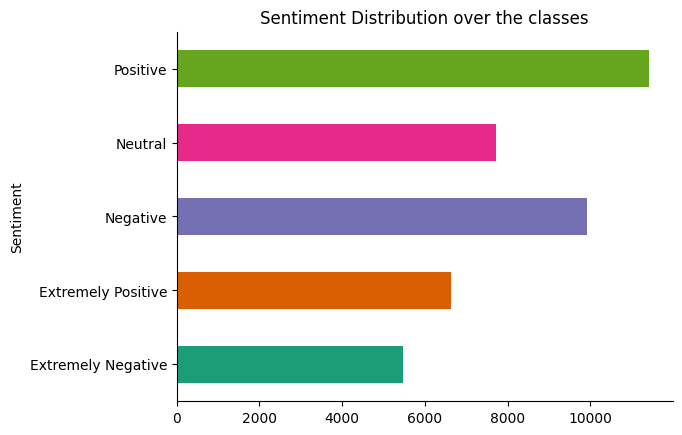

In [5]:
df.groupby('Sentiment').size().plot(kind='barh', color = sns.palettes.mpl_palette('Dark2'), title='Sentiment Distribution over the classes')
plt.gca().spines[['top', 'right']].set_visible(False)

We can see that the data is imbalanced. 
We have more tweets for the Negative class and Positive and less for the other classes.  
We can try to balance the data by using oversampling or undersampling techniques.  
But there is a risk of overfitting if we use oversampling. We can try to use the data as it is and check the model performance.  

## DATA CLEANING AND PREPROCESSING

In [17]:
import re
import string


# removing all the accents from the text to its original ascii form
def strip_accents(text):
    if isinstance(text, str):
        return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

def replace_url(text):
    if isinstance(text, str):
        text = re.sub(r'http\S+', 'URL', text)
        text = re.sub(r'https\S+', 'URL', text)
    return text
    

def replace_mention(text):
    if isinstance(text, str):
        text = re.sub(r'@\S+', 'MENTION', text)
    return text


def replace_email(text):
    if isinstance(text, str):
        text = re.sub(r'\S+@\S+', 'EMAIL', text)
    return text


def replace_emoji(text):
  emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'EMOJI', text) 

def replace_special_char(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
    return text
                
def clean_text(text):
    if isinstance(text, str):
        for char in list(string.punctuation):
            text = text.replace(char, '')
    return text

def remove_newline(text):
    if isinstance(text, str):
        text = text.replace('\n', ' ')
        text = text.replace('\r', ' ')
        text = text.replace('\b', ' ')
    return text

def preprocess(text):    
    text = replace_url(text)
    text = replace_mention(text)
    text = replace_email(text)
    text = replace_emoji(text)
    text = replace_special_char(text)
    text = strip_accents(text)
    text = remove_newline(text)
    text = clean_text(text)
    return text


nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

In [18]:
df['OriginalTweet'] = df['OriginalTweet'].apply(preprocess)
df['OriginalTweet'] = df['OriginalTweet'].apply(lemmatize_text)

In [6]:
# Check NUll Values 
print(f"Null values in Original Tweet : {df['OriginalTweet'].isnull().sum()}")

Null values in Original Tweet : 0


In [9]:
df['OriginalTweet'][:5]

0                                                                                                                                                                                                                                         MENTION MENTION MENTION URL and URL and URL
1                                       advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
2                                                                                                                                                                        Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID19 outbreak URL
3       My food stock is not the only one which is empty      PLEASE dont panic THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need    Stay c

#### Text seems to be quite clean now. Let's check the most frequent words in the text.

# Model Building 

### Logistic Regression

In [10]:
eng_stopwords_list = list(eng_stopwords)
tfidf = TfidfVectorizer(stop_words=eng_stopwords_list)
tfidf.fit(df['OriginalTweet'])

TfidfVectorizer(stop_words=['to', 'who', 'where', 'ourselves', 'itself', 'some',
                            'only', 'yours', 'own', 'and', 'm', "didn't",
                            'herself', 'theirs', 'such', 'my', 'then', 'shan',
                            'all', 'both', 'is', 'weren', 'by', 'hadn', 'in',
                            'couldn', 't', "isn't", 'most', 'won', ...])

In [11]:
word_tfidf = tfidf.transform(df['OriginalTweet'])
word_tfidf = word_tfidf.toarray().sum(axis=0)
word_tfidf_df = pd.DataFrame({'word': tfidf.get_feature_names_out(), 'tfidf': word_tfidf})
word_tfidf_df.sort_values('tfidf', ascending=False).head(10)

,word,tfidf
50044,url,1638.934734
30685,mention,1495.795655
12622,coronavirus,1296.174463
13168,covid19,1246.320266
37486,prices,761.328823
45428,store,751.437675
46054,supermarket,745.590910
19987,food,731.764428
22305,grocery,722.415499
35839,people,603.798563


<Axes: ylabel='word'>

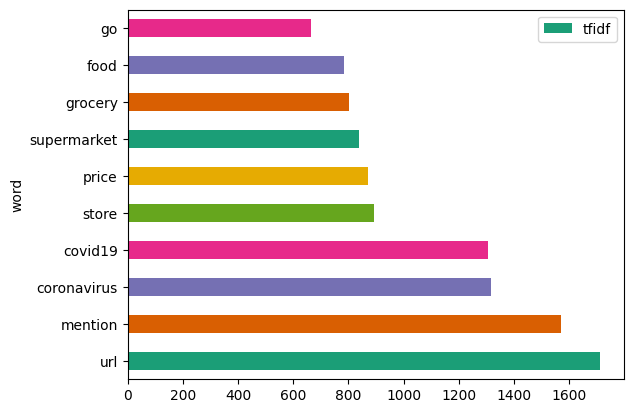

In [13]:
word_tfidf_df.sort_values('tfidf', ascending=False).head(10).plot(x='word', y='tfidf', kind='barh', color = sns.palettes.mpl_palette('Dark2'))

# Train -Test Split

In [12]:
X = df['OriginalTweet']
y = df['Sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=21)

###  Model Training

In [13]:
pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words=eng_stopwords_list)), ('lr', LogisticRegression(max_iter=10000, multi_class='ovr', class_weight='balanced', random_state=21))])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['to', 'who', 'where', 'ourselves',
                                             'itself', 'some', 'only', 'yours',
                                             'own', 'and', 'm', "didn't",
                                             'herself', 'theirs', 'such', 'my',
                                             'then', 'shan', 'all', 'both',
                                             'is', 'weren', 'by', 'hadn', 'in',
                                             'couldn', 't', "isn't", 'most',
                                             'won', ...])),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    multi_class='ovr', random_state=21))])

### Evaluation

In [12]:
y_pred = pipe_lr.predict(X_val)
print(classification_report(y_val, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.55      0.62      0.58      1349
Extremely Positive       0.60      0.69      0.64      1659
          Negative       0.50      0.44      0.47      2464
           Neutral       0.56      0.72      0.63      1921
          Positive       0.57      0.44      0.50      2897

          accuracy                           0.56     10290
         macro avg       0.56      0.58      0.56     10290
      weighted avg       0.55      0.56      0.55     10290



<b> Since the data is imbalanced, it is better to check Recall and Precision values for the classes rather than the accuracy.
The classification report shows better recall values for Neutral and Positive classes compared to Negative class. </b>

### Examples 

In [14]:
x = X_val.copy()
x.reset_index(drop=True, inplace=True)

In [21]:
for i in range(5):
    print('Original Tweet:==>', x[i])
    print('Predicted Sentiment:==>', y_pred[i])
    print('Actual Sentiment:==>', y_val.iloc[i])
    print()

Original Tweet:==> be open as usual tomorrow we will remain constant and stable with our regular supply of fabulous local produce there s definitely no need to panic the farmer and producer be always hard at work to ensure we have wonderful food and drink inthistogether Covid19 url
Predicted Sentiment:==> Extremely Positive
Actual Sentiment:==> Extremely Positive

Original Tweet:==> retailgazette ScS be consider temporarily close store amid the coronavirus outbreak       retailnew businessnews covid19UK coronavirus storeclosure retail property       URL
Predicted Sentiment:==> Neutral
Actual Sentiment:==> Neutral

Original Tweet:==> this be a great story by Luara Anderson Shaw MENTION about a local business fill an urgent need in the wake of covid19 coronavirus    Mississippi River Distilling Co to produce hand sanitizer URL url
Predicted Sentiment:==> Extremely Positive
Actual Sentiment:==> Extremely Positive

Original Tweet:==> STRONG amp UNITED WE will PREVAIL url
Predicted Sentimen

## Understand the feature importance using SHAP

In [15]:
pipe_lr.predict(X_train)

array(['Positive', 'Extremely Negative', 'Neutral', ...,
       'Extremely Positive', 'Positive', 'Extremely Positive'],
      dtype=object)

In [16]:
# feature_names = pipe_lr.named_steps['tfidf'].get_feature_names_out()
# print(feature_names)
# x_train = pipe_lr.named_steps['tfidf'].transform(X_train)
# subset_train = pipe_lr.named_steps['tfidf'].transform(X_train[:100])
# x_train

['00' '000' '0000009375' ... 'zweli' 'zwoferink' 'zzz']


<30867x45041 sparse matrix of type '<class 'numpy.float64'>'
	with 552237 stored elements in Compressed Sparse Row format>

In [29]:
vectorizer = TfidfVectorizer(min_df=10, stop_words=eng_stopwords_list)
train_transformed = vectorizer.fit_transform(X_train[:100])
test_transformed = vectorizer.transform(X_val)

In [30]:
test_transformed = vectorizer.transform(X_val[:100])

In [31]:
estimator = LogisticRegression(penalty="l2", C=0.1)
estimator.fit(train_transformed, y_train[:100])

LogisticRegression(C=0.1)

In [20]:
train_transformed

<1000x268 sparse matrix of type '<class 'numpy.float64'>'
	with 7983 stored elements in Compressed Sparse Row format>

In [24]:
import shap
shap.initjs()

In [32]:
explainer = shap.Explainer(estimator, train_transformed, feature_perturbation='correlation_dependent')

C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


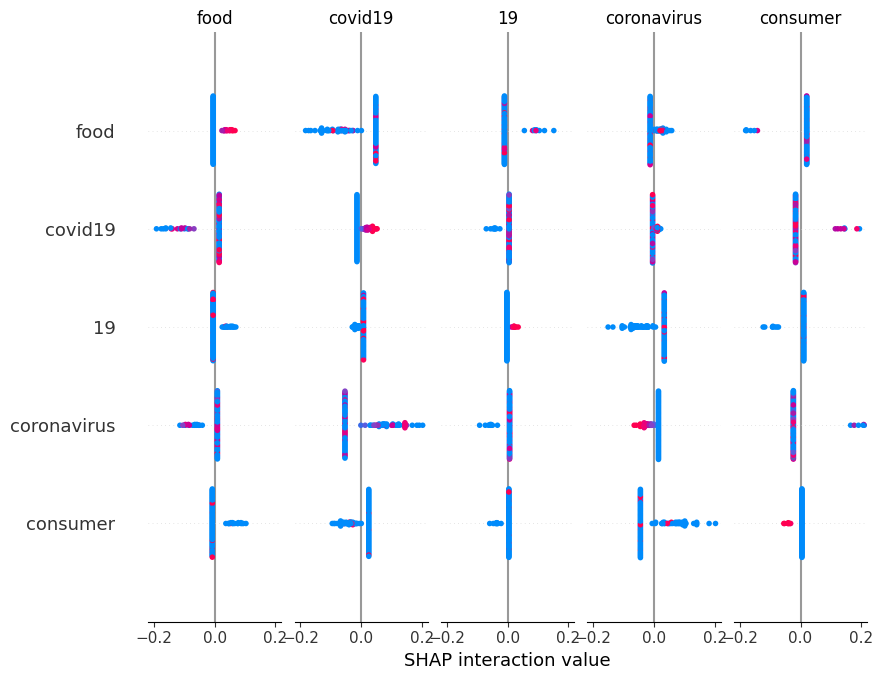

In [33]:
shap_values = explainer.shap_values(test_transformed)
X_test_array = test_transformed.toarray() 
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

There are visible interactions between certain feature pairs. For instance, "food" and "covid19" have a notable range of SHAP interaction values, suggesting that the presence of these terms together in the input data significantly impacts the model's predictions.
`The interactions between "coronavirus" and "19" also seem to have a significant spread, indicating that these terms together play an important role in the model's decision-making`.
A balanced mix of red and blue suggests that the interaction can either increase or decrease the prediction depending on the context.  

## Understand Feature importance using LIME

In [34]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [35]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'])

In [36]:
idx = 0
exp = explainer.explain_instance(X_train[idx], pipe_lr.predict_proba, num_features=10, top_labels=5)
exp.show_in_notebook(text=True)

In [37]:
idx = 0
print("Question: \n", X_train[idx])
print("Probability (Positive) =", pipe_lr.predict_proba([X_train[idx]])[0, 0])
print("Probability (Negative) =", pipe_lr.predict_proba([X_train[idx]])[0, 1])
print("Probability (Neutral) =", pipe_lr.predict_proba([X_train[idx]])[0, 2])
print("Probability (Extremely Positive) =", pipe_lr.predict_proba([X_train[idx]])[0, 3])
print("Probability (Extremely Negative) =", pipe_lr.predict_proba([X_train[idx]])[0, 4])
print("True Class is:", y_train[idx])

Question: 
 Feel horrible ordering delivery itAs our first time Aeating outA in nearly a month so tipped our driver 35 and left them a pocketsized hand sanitizer We are living in very strange times COVID19 coronavirus URL
Probability (Positive) = 0.130425905707155
Probability (Negative) = 0.18211719851740885
Probability (Neutral) = 0.27582577015934573
Probability (Extremely Positive) = 0.0823119611666333
Probability (Extremely Negative) = 0.3293191644494572
True Class is: Negative


The model predicts that the text is most likely "Extremely Negative" with a probability of 33%. The true class provided is "Negative.
 `The word "hand" contributes positively to the prediction with a value of 0.1460, suggesting it increases the likelihood of the predicted class`.  
`The word "strange" contributes negatively with a value of -0.03649, decreasing the likelihood of the predicted class.`  
`The word "horrible" contributes negatively with a value of -0.0297, also decreasing the likelihood of the predicted class.`  `The word "sanitizer" contributes positively with a value of 0.017.The word "coronavirus" contributes negatively with a value of -0.02.`  
**The combination of these word contributions results in the highest probability being assigned to the "Extremely Negative" class (33%).**
*The model's prediction does not match the true class ("Negative"). This discrepancy might be due to the mixed contributions of various words and their context within the text.*

In [38]:
exp.as_list()

[('hand', 0.14607167196309867),
 ('driver', -0.040389714245646746),
 ('strange', -0.03649061780440788),
 ('horrible', -0.02971137884798834),
 ('ordering', 0.02227804388171378),
 ('coronavirus', -0.021361150540740996),
 ('left', -0.01999470638067781),
 ('outA', -0.01731357636339285),
 ('sanitizer', 0.017141302023845634),
 ('first', 0.014187014442920262)]

## Random Forest Classifier

In [40]:
# Random Forest Classifier
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=eng_stopwords_list)), ('rf', RandomForestClassifier(n_estimators=100, random_state=21))])

In [41]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['to', 'who', 'where', 'ourselves',
                                             'itself', 'some', 'only', 'yours',
                                             'own', 'and', 'm', "didn't",
                                             'herself', 'theirs', 'such', 'my',
                                             'then', 'shan', 'all', 'both',
                                             'is', 'weren', 'by', 'hadn', 'in',
                                             'couldn', 't', "isn't", 'most',
                                             'won', ...])),
                ('rf', RandomForestClassifier(random_state=21))])

In [42]:
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.66      0.39      0.49      1349
Extremely Positive       0.67      0.39      0.49      1659
          Negative       0.47      0.48      0.47      2464
           Neutral       0.52      0.72      0.61      1921
          Positive       0.48      0.55      0.51      2897

          accuracy                           0.52     10290
         macro avg       0.56      0.51      0.51     10290
      weighted avg       0.54      0.52      0.51     10290



In [43]:
accuracy_score(y_val, y_pred)

0.5186588921282799

The model is performing better than the Logistic Regression model. The model is able to classify the positive and negative classes better than the previous model. We can try to improve the model further by tuning the hyperparameters.

## Hyperparameter Tuning

In [45]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, 40, 50],
    # 'rf__min_samples_split': [2, 5, 10],
    # 'rf__min_samples_leaf': [1, 2, 4],
    # 'rf__class_weight': ['balanced', 'balanced_subsample']
}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['to', 'who',
                                                                    'where',
                                                                    'ourselves',
                                                                    'itself',
                                                                    'some',
                                                                    'only',
                                                                    'yours',
                                                                    'own',
                                                                    'and', 'm',
                                                                    "didn't",
                                                                    'herself',
                                                                    'theirs',
                                                                    'such',
                                                                    'my',
                                                                    'then',
                                                                    'shan',
                                                                    'all',
                                                                    'both',
                                                                    'is',
                                                                    'weren',
                                                                    'by',
                                                                    'hadn',
                                                                    'in',
                                                                    'couldn',
                                                                    't',
                                                                    "isn't",
                                                                    'most',
                                                                    'won', ...])),
                                       ('rf',
                                        RandomForestClassifier(random_state=21))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20, 30, 40, 50],
                         'rf__n_estimators': [100, 200, 300]})

In [46]:
grid.best_params_

{'rf__max_depth': 50, 'rf__n_estimators': 300}

In [47]:
print(f"best score : {grid.best_score_}, best params : {grid.best_params_} , best estimator : {grid.best_estimator_} ")

best score : 0.45242475998831033, best params : {'rf__max_depth': 50, 'rf__n_estimators': 300} , best estimator : Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['to', 'who', 'where', 'ourselves',
                                             'itself', 'some', 'only', 'yours',
                                             'own', 'and', 'm', "didn't",
                                             'herself', 'theirs', 'such', 'my',
                                             'then', 'shan', 'all', 'both',
                                             'is', 'weren', 'by', 'hadn', 'in',
                                             'couldn', 't', "isn't", 'most',
                                             'won', ...])),
                ('rf',
                 RandomForestClassifier(max_depth=50, n_estimators=300,
                                        random_state=21))]) 


In [48]:
y_pred = grid.predict(X_val)

In [49]:
print(classification_report(y_val, y_pred))

                    precision    recall  f1-score   support

Extremely Negative       0.78      0.16      0.26      1349
Extremely Positive       0.79      0.23      0.36      1659
          Negative       0.46      0.40      0.43      2464
           Neutral       0.61      0.37      0.46      1921
          Positive       0.38      0.82      0.52      2897

          accuracy                           0.45     10290
         macro avg       0.61      0.40      0.41     10290
      weighted avg       0.56      0.45      0.43     10290



The model is performing better now. We can see that the model is able to classify the positive and negative classes better than before. 
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate. In this case, a precision of ~80% for the Extremely Negative and Extremely Positive  classes means that when the model predicts an instance to be negative or positive, it is correct about 80% of the time.  
Recall (Sensitivity) is the ratio of correctly predicted positive observations to the all observations in actual class. High recall means that the model correctly identified a high proportion of the positive instances.
In summary, the model is quite precise - when it predicts an instance to be positive or negative, it is usually correct. However, it is not very sensitive - it is missing a lot of actual positive or negative instances.

We can try to improve the model further by using deep learning techniques.

In [50]:
accuracy_score(y_val, y_pred)

0.45383867832847424

## Deep Learning LSTM model with GLOVE Embeddings

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors

In [23]:
class DataProcessor:
    def __init__(self,test_size=0.25):
        self.test_size = test_size
        self.tokenizer = Tokenizer(num_words=10000)
        self.filepath = r'C:\Users\a.m.ramachandran\PycharmProjects\CodeQuestions\SentimentAnalysis\glove.6B\glove.6B.300d.txt'
        self.embedding_dim = 300

    def tokenize(self, data):
        # tokenizer = Tokenizer(num_words=10000)
        self.tokenizer.fit_on_texts(data)
        print("Found %s unique tokens" %len(self.tokenizer.word_index))
        return self.tokenizer
    
    def pad_sequences(self, data):
        X = self.tokenizer.texts_to_sequences(data)
        X = pad_sequences(X, maxlen=360)
        return X
    
    def encoder(self, target):
        y = pd.get_dummies(target, drop_first=True)
        return y
    
    def split_data(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=21)
        return X_train, X_val, y_train, y_val    
            
    def get_embeddings(self):
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
         
        # Adding again 1 because of reserved 0 index
        embedding_matrix_vocab = np.zeros((vocab_size, self.embedding_dim))
     
        with open(self.filepath, encoding="utf8") as f:
            for line in f:
                word, *vector = line.split()
                if word in word_index:
                    idx = word_index[word]
                    embedding_matrix_vocab[idx] = np.array(
                        vector, dtype=np.float32)[:self.embedding_dim]
     
        return embedding_matrix_vocab
    
    def pipe(self, X, y):
        tokenizer = self.tokenize(X)
        X = self.pad_sequences(X)
        y = self.encoder(y)
        embedding_matrix_vocab = self.get_embeddings()
        return X, y, tokenizer, embedding_matrix_vocab
        

    
class DataAugmentation:
    
    def index_to_word(self, word_index):
        # data_process = DataProcessor()
        # tokenizer = data_process.tokenize()
        index_word = {0: ''}
        for word in word_index.keys():
            index_word[word_index[word]] = word
        return index_word
                    
    def create_neighboring_matrix(self, tokenizer, embedding_matrix_vocab, synonyms_number=5, word_number=2000):
        # tokenizer = self.data_process.tokenize()
        
        index_word = {0: ''}
        for word in tokenizer.word_index.keys():
            index_word[tokenizer.word_index[word]] = word       
        nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embedding_matrix_vocab) 
        neighbours_mat = nn.kneighbors(embedding_matrix_vocab[1:word_number])[1]
        synonyms = {x[0]: x[1:] for x in neighbours_mat}
        return synonyms
    
    
    def modify_sentence(self, sentence, synonyms, p=0.5):
        for i in range(len(sentence)):
            if np.random.random() > p:
                try:
                    syns = synonyms[sentence[i]]
                    sentence[i] = np.random.choice(syns)
                except KeyError:
                    pass
        return sentence 
    
    def generate_augmented_data(self, df, synonyms, indexes=None, index_word=None):
        
        # index_word = self.index_to_word()
        augmented_data = []
        for x in df[indexes]:
            sample =  np.trim_zeros(x)
            modified = self.modify_sentence(sample, synonyms)
            sentence_m = ' '.join([index_word[x] for x in modified])
            augmented_data.append(sentence_m)
        print(f"Count : {len(augmented_data)}")
        return augmented_data

In [21]:
# Cleaning the data
df_train = train_df.copy()
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(preprocess)
df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(lemmatize_text)

In [66]:
# Data Processing
X = df_train['OriginalTweet']
y = df_train['Sentiment']

data_processor = DataProcessor()
# Tokenization and padding
X_train_,y_train_, tokenizer, embedding_matrix_vocab = data_processor.pipe(X, y)
word_index = tokenizer.word_index

data_augmentor = DataAugmentation()
index_word = data_augmentor.index_to_word(word_index)
print(index_word)
neighbouring_matrix = data_augmentor.create_neighboring_matrix(tokenizer, embedding_matrix_vocab, synonyms_number=5, word_number=2000)

Found 48819 unique tokens
{0: '', 1: 'the', 2: 'to', 3: 'be', 4: 'and', 5: 'url', 6: 'of', 7: 'a', 8: 'in', 9: 'mention', 10: 'coronavirus', 11: 'covid19', 12: 'for', 13: 'i', 14: 'have', 15: 'you', 16: 'on', 17: 'price', 18: 'store', 19: 'this', 20: 'we', 21: 'at', 22: 'supermarket', 23: 'not', 24: 'food', 25: 'grocery', 26: 'with', 27: 'that', 28: 'as', 29: 'do', 30: 'it', 31: 'they', 32: 'people', 33: 'go', 34: 'from', 35: 'consumer', 36: 'amp', 37: 'all', 38: 'will', 39: 'your', 40: 'can', 41: 'get', 42: 'my', 43: 'our', 44: 'up', 45: 'out', 46: 'by', 47: '19', 48: 'more', 49: 'or', 50: 'but', 51: 'if', 52: 'need', 53: 'online', 54: 'how', 55: 'covid', 56: 'their', 57: 'during', 58: 'pandemic', 59: 'so', 60: 'now', 61: 'time', 62: 'no', 63: 'work', 64: 'about', 65: 'what', 66: 'worker', 67: 'shopping', 68: 'who', 69: 'hand', 70: 's', 71: 'just', 72: 'help', 73: 'make', 74: 'sanitizer', 75: 'panic', 76: 'stock', 77: 'like', 78: 'see', 79: 'home', 80: 'buy', 81: 'demand', 82: 'shop',

In [67]:
print(f"Number of samples for all classes : {df_train.groupby('Sentiment').size()}")

Number of samples for all classes : Sentiment
Extremely Negative     5481
Extremely Positive     6624
Negative               9917
Neutral                7713
Positive              11422
dtype: int64


## **Data Augmentation**

In [68]:
# Augmenting the data for Extremely Positive class
indexes_ext_pos = np.where(y_train_['Extremely Positive']== True)
augmented_data_ext_pos = data_augmentor.generate_augmented_data(X_train_, neighbouring_matrix,  indexes=indexes_ext_pos[0][:1000], index_word=index_word)
print(augmented_data_ext_pos)
print(f"Augmented data for Extremely Positive class :{len(augmented_data_ext_pos)}")


# Augmenting the data for Extremely Negative class
indexes_ext_neg = np.where(y_train_.apply(lambda row: all(row == False), axis=1))
print(indexes_ext_neg)
augmented_data_ext_neg = data_augmentor.generate_augmented_data(X_train_, neighbouring_matrix, indexes=indexes_ext_neg[0][:2000], index_word=index_word)
print(f"Augmented data for Extremely Negative class :{len(augmented_data_ext_neg)}")

# # Augmenting the data for Neutral class
indexes_ext_neutral = np.where(y_train_['Neutral']== True)
print(indexes_ext_neutral, len(indexes_ext_neutral[0]))
augmented_data_neutral = data_augmentor.generate_augmented_data(X_train_, neighbouring_matrix, indexes = indexes_ext_neutral[0][:1000] , index_word=index_word )
print(f"Augmented data for Neutral class :{len(augmented_data_neutral)}")

Count : 1000
['despite able the covid19 situation think been increase moreover time all food example which wo time may be so for all users orders particularly cow share both freezer pack we wish know for your patience during fact time', 'been a caring community letas all look before part less capable in need village while guarantee they leave healthy shop would they inside help with online grocery well self isolation not you already symptoms rather be covid19 to somebody who had url', 'amazon whole foods fresh grocery deliveries aa covid19 have rapidly covid2019 look this significant increases same some bakery online while a say the a monday atoday this result last another example impact affect their homepage', 'we been amazing easy deal for the covid2019 go next help help know monthly yearly and higher subscription but dm us iptv service iptv cheap iptv football hd movies adult cinema male', 'think they amazing cheap negotiate but the covid2019 let on would helps want monthly yearly b

In [70]:
df_aug = df_train.copy()
data_ext_pos = pd.DataFrame({'OriginalTweet': augmented_data_ext_pos, 'Sentiment': 'Extremely Positive'})
data_ext_neg = pd.DataFrame({'OriginalTweet': augmented_data_ext_neg, 'Sentiment': 'Extremely Negative'})
data_ext_neutral = pd.DataFrame({'OriginalTweet': augmented_data_neutral, 'Sentiment': 'Neutral'})
# Joining all of them
df_aug = pd.concat([df_aug, data_ext_pos, data_ext_neg, data_ext_neutral])

In [71]:
df_aug.shape , df_train.shape

((45157, 6), (41157, 6))

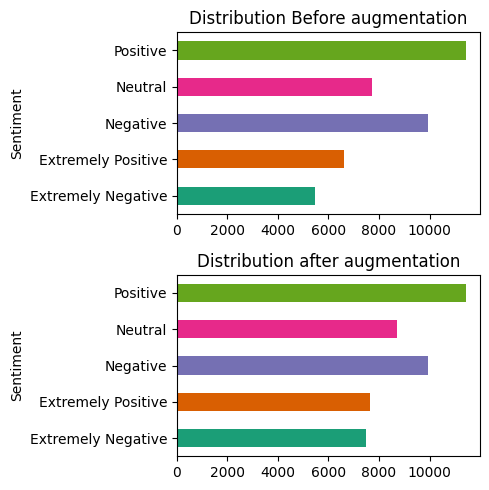

In [72]:
fig, axs = plt.subplots(2,1, figsize=(5, 5))
df_aug.groupby('Sentiment').size().plot(kind='barh', color = sns.palettes.mpl_palette('Dark2'), title='Distribution after augmentation', ax=axs[1])
df_train.groupby('Sentiment').size().plot(kind='barh', color = sns.palettes.mpl_palette('Dark2'), title='Distribution Before augmentation', ax=axs[0])

plt.tight_layout()
plt.show()

**Building Model**

In [25]:
# Data Processing
X = df_aug['OriginalTweet']
y = df_aug['Sentiment']

data_processor = DataProcessor()
X_train, X_val, y_train, y_val = data_processor.split_data(X, y)
# Tokenization and padding
X_train_,y_train_, tokenizer, embedding_matrix_vocab = data_processor.pipe(X_train, y_train)
X_val_, y_val_ , tokenizer , embedding_matrix_vocab = data_processor.pipe(X_val, y_val)

Found 45314 unique tokens
Found 53618 unique tokens


In [26]:
print(f"size of embedding_matrix : {embedding_matrix_vocab.shape}")
vocab_size = len(tokenizer.word_index) +1
print(f"vocab size : {vocab_size}")
max_len=360
embedding_dim = 300

size of embedding_matrix : (53619, 300)
vocab size : 53619


**Create Model**

In [75]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

In [78]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix_vocab], input_length= max_len, trainable=False))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    14,646,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,646,000 (55.87 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,646,000 (55.87 MB)

In [79]:
model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=15, batch_size=64)

Epoch 1/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.2720 - loss: 1.2509 - val_accuracy: 0.2986 - val_loss: 1.1037
Epoch 2/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.2492 - loss: 1.2459 - val_accuracy: 0.2583 - val_loss: 1.1508
Epoch 3/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 807s 2s/step - accuracy: 0.2470 - loss: 1.1973 - val_accuracy: 0.1932 - val_loss: 1.1582
Epoch 4/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 878s 2s/step - accuracy: 0.2452 - loss: 1.1746 - val_accuracy: 0.2583 - val_loss: 1.1598
Epoch 5/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.2415 - loss: 1.1609 - val_accuracy: 0.2583 - val_loss: 1.1583
Epoch 6/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 866s 2s/step - accuracy: 0.2442 - loss: 1.1659 - val_accuracy: 0.2583 - val_loss: 1.1547
Epoch 7/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 926s 2s/step - accuracy: 0.2380 - loss: 1.1587 - val_accuracy: 0.2190 - val_loss: 1.1590
Epoch 8/15
530/530 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.2380 - loss: 1.1576 - val_accu

In [82]:
model.save(r'C:\Users\a.m.ramachandran\PycharmProjects\CodeQuestions\SentimentAnalysis\model_lstm.keras')

In [12]:
saved_model = tf.keras.models.load_model(r'C:\Users\a.m.ramachandran\PycharmProjects\CodeQuestions\SentimentAnalysis\model_lstm.keras')

In [106]:
y_pred = saved_model.predict(X_val_)

353/353 ━━━━━━━━━━━━━━━━━━━━ 143s 406ms/step


In [107]:
y_pred = model.predict(X_val_)

353/353 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step


In [111]:
y_pred = saved_model.predict(X_val_)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val_.values, axis=1)
accuracy_score(y_val, y_pred)

353/353 ━━━━━━━━━━━━━━━━━━━━ 113s 320ms/step


0.21895482728077945

In [112]:
from sklearn.metrics import recall_score, precision_score, f1_score

print(f"Recall : {recall_score(y_val, y_pred, average='weighted')}, Precision : {precision_score(y_val, y_pred, average='weighted')}, F1 Score : {f1_score(y_val, y_pred, average='weighted')}")

Recall : 0.21895482728077945, Precision : 0.04794971058097863, F1 Score : 0.0786709786392568


C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Stratified Splitting of Training data proportional to the CLasses**

In [115]:
# Data Processing
X = df_aug['OriginalTweet']
y = df_aug['Sentiment']

data_processor = DataProcessor()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=21, stratify=y)
# Tokenization and padding
X_train_,y_train_, tokenizer, embedding_matrix_vocab = data_processor.pipe(X_train, y_train)
X_val_, y_val_ , tokenizer , embedding_matrix_vocab = data_processor.pipe(X_val, y_val)

Found 41062 unique tokens
Found 48819 unique tokens


In [116]:
model.fit(X_train_, y_train_, validation_data=(X_val_, y_val_), epochs=5, batch_size=64)

Epoch 1/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.2432 - loss: 1.1558 - val_accuracy: 0.2530 - val_loss: 1.1499
Epoch 2/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.2472 - loss: 1.1536 - val_accuracy: 0.2197 - val_loss: 1.1584
Epoch 3/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 643s 1s/step - accuracy: 0.2404 - loss: 1.1533 - val_accuracy: 0.2197 - val_loss: 1.1658
Epoch 4/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.2409 - loss: 1.1608 - val_accuracy: 0.2530 - val_loss: 1.1484
Epoch 5/5
530/530 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.2367 - loss: 1.1571 - val_accuracy: 0.2530 - val_loss: 1.1612


In [120]:
y_pred = model.predict(X_val_)

353/353 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step


In [121]:
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_.values, axis=1)
accuracy_score(y_true, y_pred)

0.2529672276350753

In [124]:
from sklearn.metrics import recall_score, precision_score, f1_score

print(f"Recall : {recall_score(y_true, y_pred, average='weighted')}, Precision : {precision_score(y_true, y_pred, average='weighted')}, F1 Score : {f1_score(y_true, y_pred, average='weighted')}")

Recall : 0.2529672276350753, Precision : 0.06399241825737599, F1 Score : 0.1021453982929132


C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
print(classification_report(y_true, y_pred ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3776
           1       0.00      0.00      0.00      2480
           2       0.00      0.00      0.00      2178
           3       0.25      1.00      0.40      2856

    accuracy                           0.25     11290
   macro avg       0.06      0.25      0.10     11290
weighted avg       0.06      0.25      0.10     11290



C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\a.m.ramachandran\llm_env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
y_pred = saved_model.predict(X_val_)

322/322 ━━━━━━━━━━━━━━━━━━━━ 64s 198ms/step


In [28]:
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_.values, axis=1)
accuracy_score(y_true, y_pred)

0.23945578231292516

In [29]:
print(classification_report(y_true, y_pred, zero_division=0.0, target_names=y_val_.columns))

                    precision    recall  f1-score   support

Extremely Positive       0.00      0.00      0.00      3008
          Negative       0.24      1.00      0.39      2464
           Neutral       0.00      0.00      0.00      1921
          Positive       0.00      0.00      0.00      2897

          accuracy                           0.24     10290
         macro avg       0.06      0.25      0.10     10290
      weighted avg       0.06      0.24      0.09     10290




**Extremely Positive, Neutral, and Positive Classes:**

`The LSTM model completely failed to predict these classes correctly. This is indicated by precision, recall, and F1-score all being zero. This means the model didn't make any correct predictions for these classes.`
#### Negative Class:

`The model managed to recall all instances of the negative class (recall of 1.00) but with low precision (0.24). This indicates the model classified many instances as negative, including many that were not actually negative, resulting in many false positives.`
#### Accuracy:

`The overall accuracy is very low at 24%, meaning the model correctly predicted the sentiment of only 24% of the tweets.`

##### Macro Average:
`This average calculates the mean of precision, recall, and F1 scores for all classes independently and then takes the average. This metric shows the model's overall performance without considering class imbalance.`

#### Weighted Average:
 
`This average calculates the mean of precision, recall, and F1 scores for all classes, weighted by the number of true instances for each class. This takes class imbalance into account.`


<b> Deep Learning doesnt seem to be working well. It could be because of the increased complexity of the model.
Because of the increased complexity, the model is not able to generalize well on the validation data. </b>

## ***Conclusion***
=================================

#### <italic>The Tweets Dataset is quite similar to each other because they describe the same Pandemic Situation, making it difficult to differentiate between sentiments unless the context is understood. </italic> </b> 
#### <italic>As a result, a model capable of understanding the context should perform well.</italic> </b> 
#### <italic>We can use BERT or ROBERTA model for this purpose.</italic> </b>

# ***ROBERTA***

#### =====> `Roberta Model trained for 1 EPOCH due to resource limitations`

In [3]:
ROBERTA_MODEL_PATH = r'C:\Users\a.m.ramachandran\PycharmProjects\fastApiProject\app\best_model_state.bin'
Roberta_evaluate_script_path = r'C:\Users\a.m.ramachandran\PycharmProjects\fastApiProject\Scripts\evaluate_roberta.py'

In [4]:
roberta_predictions_path = r'C:\Users\a.m.ramachandran\PycharmProjects\fastApiProject\app\test_df_predictions.csv'
test_predictions = pd.read_csv(roberta_predictions_path, encoding='latin1')

In [5]:
True_values = test_predictions['Sentiment']
preds = test_predictions['predictions']
type(True_values), type(preds)

(pandas.core.series.Series, pandas.core.series.Series)

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(True_values, preds)

0.6893101632438126

In [7]:
from sklearn.metrics import classification_report
print(classification_report(True_values, preds, zero_division=0.0))

                    precision    recall  f1-score   support

Extremely Negative       0.75      0.74      0.75       592
Extremely Positive       0.76      0.72      0.74       599
          Negative       0.63      0.69      0.66      1041
           Neutral       0.81      0.71      0.76       619
          Positive       0.61      0.63      0.62       947

          accuracy                           0.69      3798
         macro avg       0.71      0.70      0.70      3798
      weighted avg       0.69      0.69      0.69      3798



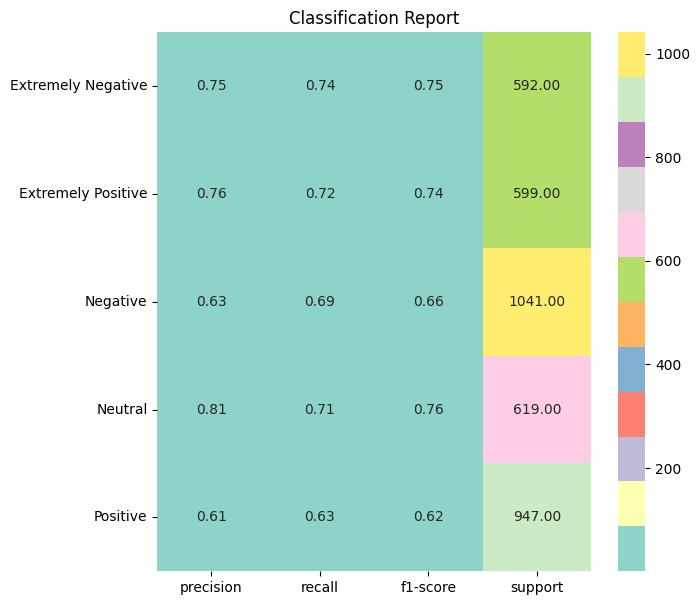

In [39]:
# Plot the classification report 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, figsize=(7, 7)):
    report = classification_report(y_true, y_pred, output_dict=True)
    report.pop('accuracy', None)
    report.pop('macro avg', None)
    report.pop('weighted avg', None)
    report_df = pd.DataFrame(report).T
    plt.figure(figsize=figsize)
    sns.heatmap(report_df, annot=True, fmt='.2f', cmap='Set3')
    plt.title('Classification Report')
    plt.show()
plot_classification_report(True_values, preds)

### We can see Roberta acheived almost 70% accuracy on the test data after training for just 1 epoch </b>